In [1]:
import collections
import itertools
import pathlib
import random
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
from matplotlib.patches import Patch
sns.set_context("talk")

In [2]:
db_path = pathlib.Path('instacart.db')

def sql_data(statement):
    conn = sqlite3.Connection(db_path)
    table = pd.read_sql(statement, conn)
    conn.close()
    return table

# Customer Information Analysis

## Total number of orders

In [3]:
statement = 'SELECT * from orders;'
orders =sql_data(statement)
Num_orders = orders.groupby(["user_id"]).agg({'order_id':"count"})
Num_orders.columns = ['total orders']
Num_orders

,total orders
user_id,
1,10
2,14
3,12
4,5
5,4
...,...
206205,3
206206,67
206207,16


In [4]:
Num_orders.describe()

,total orders
count,206209.000000
mean,15.590367
std,16.654774
min,3.000000
25%,5.000000
50%,9.000000
75%,19.000000
max,99.000000


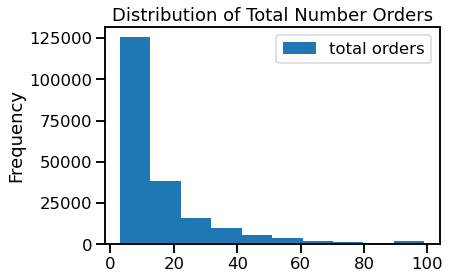

In [5]:
Num_orders.plot(kind='hist')
plt.title("Distribution of Total Number Orders")
plt.show()

## Avg number of items in order

In [6]:
statement = 'SELECT user_id, o.order_id, product_id, reordered from orders o inner join order_details od on o.order_id=od.order_id;'
user_items= sql_data(statement)

In [7]:
Num_items = user_items.groupby('user_id')['product_id'].count()
Num_order = user_items.groupby('user_id')['order_id'].nunique()
Q3 = pd.concat([Num_items,Num_order],axis=1)
Q3['avg_items_in_order'] = round(Q3['product_id']/Q3['order_id'],1)
Q3.drop(columns=['product_id','order_id'],inplace=True)
Q3.head()

,avg_items_in_order
user_id,
1,5.9
2,13.9
3,7.3
4,3.6
5,9.2


In [8]:
Q3.describe()

,avg_items_in_order
count,206209.000000
mean,9.951592
std,5.863743
min,1.000000
25%,5.700000
50%,8.900000
75%,13.000000
max,70.200000


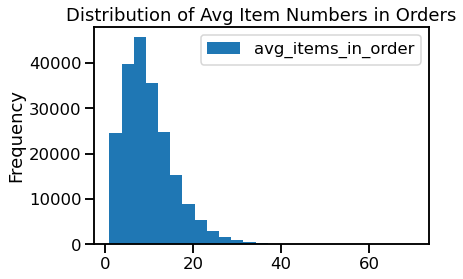

In [9]:
Q3.plot(kind='hist',bins=25)
plt.title("Distribution of Avg Item Numbers in Orders")
plt.show()

## Percentage of each days’ order

In [10]:
customer_dow=orders.groupby(["user_id","order_dow"])['order_id'].count().reset_index()
customer_dow['total']= customer_dow.groupby('user_id')['order_id'].transform('sum')
customer_dow['proportion'] = customer_dow['order_id']/customer_dow['total']
customer_dow=customer_dow.pivot(
    index='user_id',
    columns='order_dow',
    values='proportion',
)
customer_dow = customer_dow.fillna(0)
customer_dow.columns = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
customer_dow.head()

,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday
user_id,,,,,,,
1,0.00,0.300000,0.200000,0.200000,0.300000,0.000000,0.0
2,0.00,0.357143,0.357143,0.142857,0.071429,0.071429,0.0
3,0.50,0.166667,0.083333,0.250000,0.000000,0.000000,0.0
4,0.00,0.000000,0.000000,0.000000,0.400000,0.400000,0.2
5,0.25,0.250000,0.000000,0.500000,0.000000,0.000000,0.0


## Percentage of customer’s purchase time range
(7am-12pm : morning; 12pm-5pm : afternoon; 5pm-10pm : evening; 10pm-7am : midnight)

In [11]:
def to_timeperiod(num):
    if 12 > num >= 7:
        return "Morning"
    elif 17 > num >= 12:
        return "Afternoon"
    elif 22 > num >= 17:
        return "Evening"
    else:
        return "Midnight"

orders['period']= orders["order_hour_of_day"].apply(to_timeperiod)

order_period = orders.groupby(["user_id","period"])['order_id'].count().reset_index()
order_period['total']= order_period.groupby('user_id')['order_id'].transform('sum')
order_period['proportion'] = order_period['order_id']/order_period['total']
order_period=order_period.pivot(
    index='user_id',
    columns='period',
    values='proportion')
order_period = order_period.fillna(0)
order_period

period,Afternoon,Evening,Midnight,Morning
user_id,,,,
1,0.400000,0.000000,0.000000,0.600000
2,0.142857,0.000000,0.000000,0.857143
3,0.583333,0.416667,0.000000,0.000000
4,0.600000,0.000000,0.000000,0.400000
5,0.500000,0.500000,0.000000,0.000000
...,...,...,...,...
206205,1.000000,0.000000,0.000000,0.000000
206206,0.388060,0.597015,0.000000,0.014925
206207,0.375000,0.187500,0.062500,0.375000


## Order frequency (average how many days between each order)

In [12]:
order_freq = orders.groupby("user_id").agg({"days_since_prior_order":"mean"})
order_freq.columns=["avg_days_since_prior"]
order_freq

,avg_days_since_prior
user_id,
1,19.555556
2,15.230769
3,12.090909
4,13.750000
5,13.333333
...,...
206205,20.000000
206206,3.772727
206207,14.333333


## Customer item reorder rate

In [13]:
groupby_columns = ['user_id']
agg_dict = {
    'reordered': ['sum', 'count'],
}
user_reorder=user_items.groupby(groupby_columns).agg(agg_dict)
user_reorder.columns=['reorder_times','total_times']
user_reorder["reorder_rate"]=user_reorder['reorder_times']/user_reorder['total_times']
user_reorder=user_reorder[['reorder_rate',]]
user_reorder

,reorder_rate
user_id,
1,0.694915
2,0.476923
3,0.625000
4,0.055556
5,0.378378
...,...
206205,0.250000
206206,0.473684
206207,0.587444


## Concat all the tables and save as CSV file

In [14]:
customer = pd.concat([Num_orders,Q3,order_freq,user_reorder,customer_dow,order_period],axis=1)
customer.head()
customer.to_csv("Customer_features.csv")

# Customer Clustering

## Use customer dataset or read from csv file

In [15]:
try:
    customer.head()
except:
    customer = pd.read_csv("Customer_features.csv",index_col="user_id")
customer.head()

,total orders,avg_items_in_order,avg_days_since_prior,reorder_rate,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Afternoon,Evening,Midnight,Morning
user_id,,,,,,,,,,,,,,,
1,10,5.9,19.555556,0.694915,0.00,0.300000,0.200000,0.200000,0.300000,0.000000,0.0,0.400000,0.000000,0.0,0.600000
2,14,13.9,15.230769,0.476923,0.00,0.357143,0.357143,0.142857,0.071429,0.071429,0.0,0.142857,0.000000,0.0,0.857143
3,12,7.3,12.090909,0.625000,0.50,0.166667,0.083333,0.250000,0.000000,0.000000,0.0,0.583333,0.416667,0.0,0.000000
4,5,3.6,13.750000,0.055556,0.00,0.000000,0.000000,0.000000,0.400000,0.400000,0.2,0.600000,0.000000,0.0,0.400000
5,4,9.2,13.333333,0.378378,0.25,0.250000,0.000000,0.500000,0.000000,0.000000,0.0,0.500000,0.500000,0.0,0.000000


## Split into customer_feature and shopping_habits

In [16]:
customer_feature = customer.iloc[:,:4].copy()
c_shopping_habits = customer.iloc[:,4:].copy()

In [17]:
customer_feature.head()

,total orders,avg_items_in_order,avg_days_since_prior,reorder_rate
user_id,,,,
1,10,5.9,19.555556,0.694915
2,14,13.9,15.230769,0.476923
3,12,7.3,12.090909,0.625000
4,5,3.6,13.750000,0.055556
5,4,9.2,13.333333,0.378378


In [18]:
c_shopping_habits.head()

,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Afternoon,Evening,Midnight,Morning
user_id,,,,,,,,,,,
1,0.00,0.300000,0.200000,0.200000,0.300000,0.000000,0.0,0.400000,0.000000,0.0,0.600000
2,0.00,0.357143,0.357143,0.142857,0.071429,0.071429,0.0,0.142857,0.000000,0.0,0.857143
3,0.50,0.166667,0.083333,0.250000,0.000000,0.000000,0.0,0.583333,0.416667,0.0,0.000000
4,0.00,0.000000,0.000000,0.000000,0.400000,0.400000,0.2,0.600000,0.000000,0.0,0.400000
5,0.25,0.250000,0.000000,0.500000,0.000000,0.000000,0.0,0.500000,0.500000,0.0,0.000000


In [19]:
customer_feature.corr()

,total orders,avg_items_in_order,avg_days_since_prior,reorder_rate
total orders,1.000000,0.021928,-0.555102,0.636891
avg_items_in_order,0.021928,1.000000,-0.023633,0.109730
avg_days_since_prior,-0.555102,-0.023633,1.000000,-0.443848
reorder_rate,0.636891,0.109730,-0.443848,1.000000


In [20]:
c_shopping_habits.corr()

,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Afternoon,Evening,Midnight,Morning
Saturday,1.000000,-0.230319,-0.287812,-0.289793,-0.289247,-0.252433,0.018590,0.035945,0.077112,-0.010752,-0.099482
Sunday,-0.230319,1.000000,-0.043793,-0.118309,-0.153742,-0.210015,-0.301520,-0.008329,-0.075529,-0.036895,0.094165
Monday,-0.287812,-0.043793,1.000000,-0.027087,-0.067708,-0.155792,-0.274342,0.000607,-0.033866,-0.011867,0.035689
Tuesday,-0.289793,-0.118309,-0.027087,1.000000,-0.022432,-0.114193,-0.240779,-0.001366,-0.022201,0.005127,0.018844
Wednesday,-0.289247,-0.153742,-0.067708,-0.022432,1.000000,-0.056054,-0.209395,-0.013141,-0.025946,0.017050,0.027962
Thursday,-0.252433,-0.210015,-0.155792,-0.114193,-0.056054,1.000000,-0.097307,-0.007925,-0.023240,0.016641,0.020608
Friday,0.018590,-0.301520,-0.274342,-0.240779,-0.209395,-0.097307,1.000000,-0.015378,0.077712,0.027723,-0.068420
Afternoon,0.035945,-0.008329,0.000607,-0.001366,-0.013141,-0.007925,-0.015378,1.000000,-0.396521,-0.290930,-0.481804
Evening,0.077112,-0.075529,-0.033866,-0.022201,-0.025946,-0.023240,0.077712,-0.396521,1.000000,-0.036208,-0.494396
Midnight,-0.010752,-0.036895,-0.011867,0.005127,0.017050,0.016641,0.027723,-0.290930,-0.036208,1.000000,-0.168806


## K-Mean CLustering - Customer Feature

### Standardize the variable

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
std_customer_feature = scaler.fit_transform(customer_feature)

### Applying Principle Component Analysis

In [22]:
from sklearn.decomposition import PCA
pca = PCA()
pca_customer_feature = pca.fit_transform(std_customer_feature)
explained_variance= pca.explained_variance_ratio_
explained_variance

array([0.52540186, 0.25055861, 0.13992607, 0.08411346])

We can observe that 2 components can explain about 77% of the variance.

In [23]:
pca0 = PCA(n_components=2)
pca_customer_feature = pca0.fit_transform(std_customer_feature)

### K-mean with PCA data
#### Using the elbow method to find the optimal number of clusters

In [24]:
from sklearn.cluster import KMeans

def find_num_clusters(data,max_cluster=10):
    wcss = []
    for i in range(1,max_cluster+1):
        kmeans = KMeans(n_clusters=i,random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_) #measures how well the dataset was clustered by kmeans
    return wcss

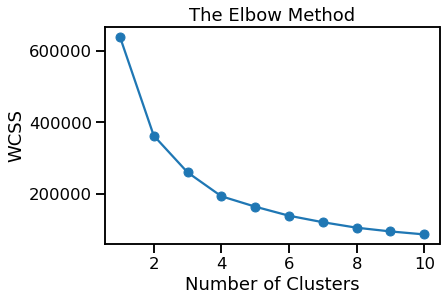

In [25]:
pca_num_clusters = find_num_clusters(pca_customer_feature)

plt.plot(range(1,11),pca_num_clusters,marker='o')
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

4 clusters is optimal choice for PCA data

#### Applying the k-means to the PCA data

In [26]:
kmeans = KMeans(n_clusters=4,random_state=0)
pca_kmeans = kmeans.fit_predict(pca_customer_feature) #compute cluster centers and predicts cluster index for each sample
customer_feature["feature_groups"]=pca_kmeans

### Visualizing the clusters

In [27]:
customer_feature.columns

Index(['total orders', 'avg_items_in_order', 'avg_days_since_prior',
       'reorder_rate', 'feature_groups'],
      dtype='object')

C:\Users\linam\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


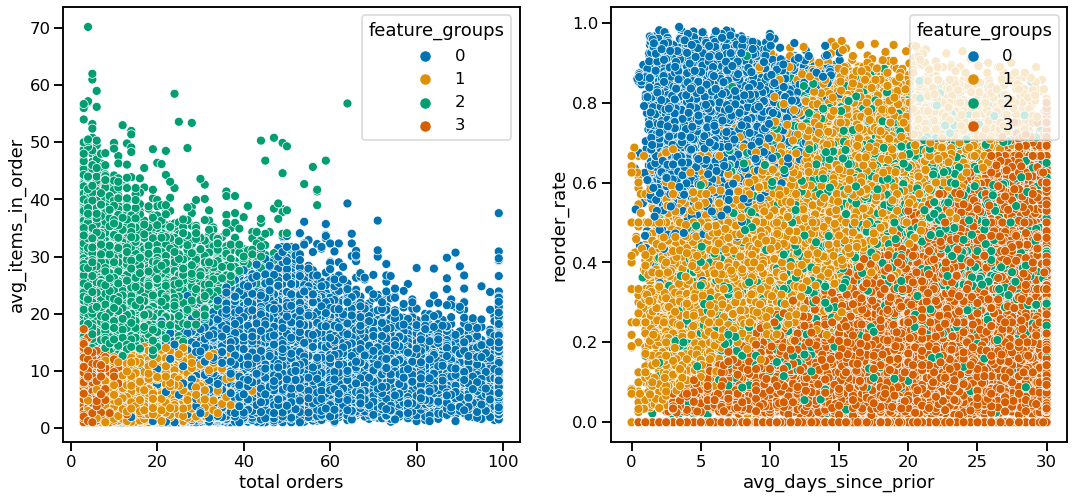

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(x='total orders',y='avg_items_in_order',hue='feature_groups',data=customer_feature,palette='colorblind',ax=ax[0])
sns.scatterplot(x='avg_days_since_prior',y='reorder_rate',hue='feature_groups',data=customer_feature,palette='colorblind',ax=ax[1])
plt.show()

## K-Mean CLustering - Shopping habbits

### Standardize the variable

In [29]:
scaler1 = StandardScaler()
std_shophab = scaler1.fit_transform(c_shopping_habits)

In [30]:
std_shophab

array([[-0.97986252,  0.79307396,  0.45983538, ..., -1.08880312,
        -0.51200112,  1.29394946],
       [-0.97986252,  1.14331481,  1.58789259, ..., -1.08880312,
        -0.51200112,  2.41841484],
       [ 1.67993819, -0.02415469, -0.37766165, ...,  0.93378253,
        -0.51200112, -1.32980308],
       ...,
       [ 0.01756275,  0.10353728,  0.37010355, ..., -0.17863958,
         0.04953578,  0.31004226],
       [-0.43704605,  0.20516967,  0.78213744, ..., -0.39534518,
         0.22143483, -0.34812696],
       [-0.57066241,  0.3687437 , -0.42367796, ...,  0.03139816,
        -0.51200112,  0.01571104]])

### Applying PCA

In [31]:
pca_shopping_habits = pca.fit_transform(std_shophab)
explained_varianceSH = pca.explained_variance_ratio_
explained_varianceSH

array([1.64260442e-01, 1.35315452e-01, 1.27748512e-01, 1.17568133e-01,
       9.66377936e-02, 9.24796620e-02, 9.10219881e-02, 9.08799350e-02,
       8.40880829e-02, 2.31326077e-30, 4.29967257e-32])

In [32]:
explained_varianceSH[0]+explained_varianceSH[1]+explained_varianceSH[2]+explained_varianceSH[3]+explained_varianceSH[4]+explained_varianceSH[5]+explained_varianceSH[6]

0.8250319821271488

We can observe that 7 components can explain 82.50% of the variance.

In [33]:
pca1 = PCA(n_components=7)
pca_c_shopping_habits = pca1.fit_transform(std_shophab)
pca_c_shopping_habits

array([[-2.56681837, -0.24945381, -0.297419  , ..., -0.78119994,
         0.89190674, -0.31731934],
       [-3.11618275,  0.86735647, -1.38645557, ...,  0.06285408,
        -0.8878741 , -0.41970172],
       [ 1.47521   , -1.19303884,  0.66286817, ..., -0.80123789,
         0.01292504,  1.13606272],
       ...,
       [-0.27417433,  0.1304649 , -0.30865233, ...,  0.05672892,
        -0.46754956, -0.05898711],
       [-0.50843633, -0.72826844,  0.42325233, ...,  0.07120759,
        -0.43873701, -0.37329118],
       [-0.9997234 , -0.35785399,  0.68623622, ..., -0.08271963,
         0.78970106,  0.72098626]])

### K-mean with PCA data
#### Using the elbow method to find the optimal number of clusters

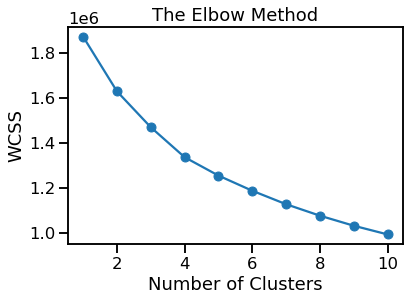

In [34]:
pca_num_clusters = find_num_clusters(pca_c_shopping_habits)

plt.plot(range(1,11),pca_num_clusters,marker='o')
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

4 clusters is optimal choice for PCA data

#### Applying the k-means to the PCA data

In [35]:
kmeansSH = KMeans(n_clusters=4,random_state=0)
pca_kmeansSH = kmeansSH.fit_predict(pca_c_shopping_habits) #compute cluster centers and predicts cluster index for each sample
c_shopping_habits["habit_groups"]=pca_kmeansSH

#### Visualizing the clusters

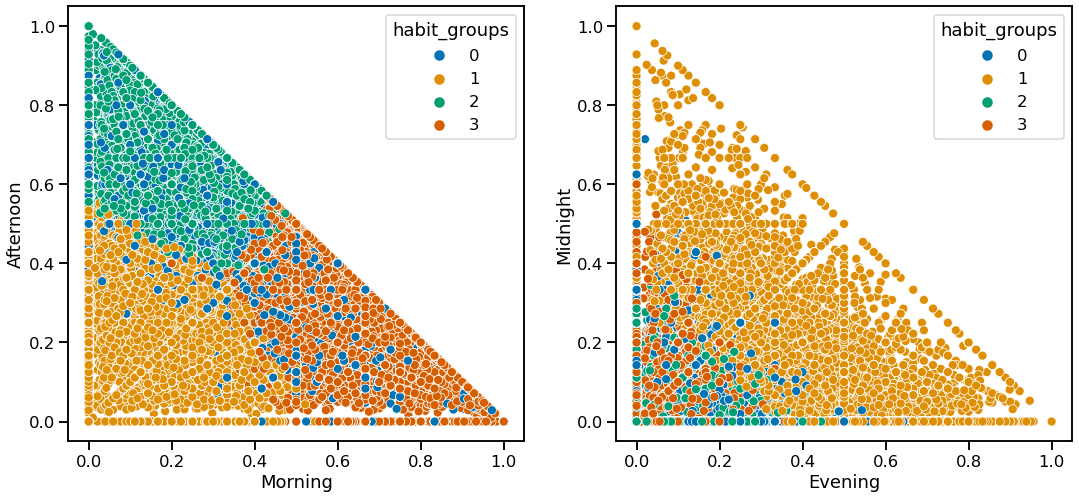

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.scatterplot(x='Morning',y='Afternoon',hue='habit_groups',data=c_shopping_habits,palette='colorblind',ax=ax[0])
sns.scatterplot(x='Evening',y='Midnight',hue='habit_groups',data=c_shopping_habits,palette='colorblind',ax=ax[1])
plt.show()

In [37]:
shopping_habits_statistics = c_shopping_habits.groupby(['habit_groups']).mean()
shopping_habits_statistics

,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Afternoon,Evening,Midnight,Morning
habit_groups,,,,,,,,,,,
0,0.388827,0.095851,0.058175,0.052095,0.050932,0.078830,0.275290,0.459034,0.189534,0.038095,0.313337
1,0.173768,0.155481,0.135831,0.130913,0.128130,0.136679,0.139197,0.262216,0.454497,0.120112,0.163175
2,0.114390,0.185551,0.167059,0.155133,0.146222,0.147989,0.083657,0.638676,0.145865,0.023607,0.191851
3,0.090817,0.238088,0.170494,0.152573,0.143850,0.137171,0.067008,0.276517,0.095419,0.044274,0.583790


In [38]:
day_time = list(shopping_habits_statistics.columns)
shopping_habits_statistics= shopping_habits_statistics.reset_index()
shopping_habits_st_long = pd.melt(shopping_habits_statistics,id_vars=['habit_groups'],value_vars=day_time)
shopping_habits_st_long
shopping_habits_st_long.columns = ['habit_group','day','value']

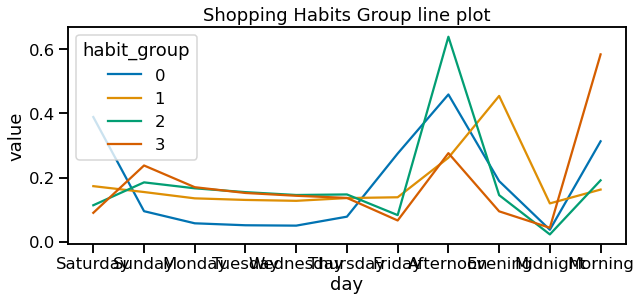

In [39]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x='day',y='value',hue='habit_group',palette="colorblind",data=shopping_habits_st_long)
plt.title("Shopping Habits Group line plot")
plt.show()

# Product Analysis

In [40]:
customer_feature = customer_feature.reset_index()
feature_group=customer_feature.loc[:,['user_id','feature_groups']]
c_shopping_habits=c_shopping_habits.reset_index()
habits_group=c_shopping_habits.loc[:,['user_id','habit_groups']]


## Which Departments products are most popular?

In [41]:
statement = 'SELECT user_id, o.order_id, p.product_id, aisle_id, department  from orders o inner join order_details od on o.order_id=od.order_id inner join products p on od.product_id = p.product_id inner join departments d on p.department_id=d.department_id;'
user_products=sql_data(statement)

In [42]:
user_products.head()

,user_id,order_id,product_id,aisle_id,department
0,202279,2,33120,86,dairy eggs
1,202279,2,28985,83,produce
2,202279,2,9327,104,pantry
3,202279,2,45918,19,pantry
4,202279,2,30035,17,pantry


In [43]:
customer_products =pd.merge(user_products,feature_group,on='user_id')
customer_products=pd.merge(customer_products,habits_group,on='user_id')

In [44]:
customer_products

,user_id,order_id,product_id,aisle_id,department,feature_groups,habit_groups
0,202279,2,33120,86,dairy eggs,3,3
1,202279,2,28985,83,produce,3,3
2,202279,2,9327,104,pantry,3,3
3,202279,2,45918,19,pantry,3,3
4,202279,2,30035,17,pantry,3,3
...,...,...,...,...,...,...,...
32434484,179441,3347806,42615,117,snacks,3,0
32434485,179441,3347806,25890,49,meat seafood,3,0
32434486,179441,3347806,16797,24,produce,3,0
32434487,179441,3347806,35221,115,beverages,3,0


In [45]:
department_orders = customer_products.groupby(['feature_groups','habit_groups','department']).agg({'user_id':'count'})
department_orders = department_orders.reset_index()
department_orders.columns=['feature_groups','habit_groups','department','num_of_orders']
department_orders

,feature_groups,habit_groups,department,num_of_orders
0,0,0,alcohol,4008
1,0,0,babies,36395
2,0,0,bakery,88818
3,0,0,beverages,154650
4,0,0,breakfast,48482
...,...,...,...,...
331,3,3,pantry,42933
332,3,3,personal care,11820
333,3,3,pets,1808
334,3,3,produce,158111


### Department by customer feature

In [46]:
department_rank = (department_orders[department_orders["feature_groups"]==0].groupby("department")[["num_of_orders"]].sum())*100/(department_orders[department_orders["feature_groups"]==0][["num_of_orders"]].sum())
department_rank.rename(columns={"num_of_orders":"group "+str(0)},inplace=True)
for i in range(1,4):
    department_temp = (department_orders[department_orders["feature_groups"]==i].groupby("department")[["num_of_orders"]].sum())*100/(department_orders[department_orders["feature_groups"]==i][["num_of_orders"]].sum())
    department_temp.rename(columns={"num_of_orders":"group "+str(i)},inplace=True)
    department_rank=pd.concat([department_rank,department_temp],axis=1)

In [47]:
department_rank=department_rank.sort_values(by='group 0',ascending=False)
department_rank.head()

,group 0,group 1,group 2,group 3
department,,,,
produce,30.675859,28.668865,27.938499,26.695806
dairy eggs,17.639875,16.061235,16.093003,15.152131
snacks,9.103118,8.568219,9.147180,8.216868
beverages,8.324970,9.276689,7.007661,8.656609
frozen,6.122335,7.164656,7.882077,7.603749


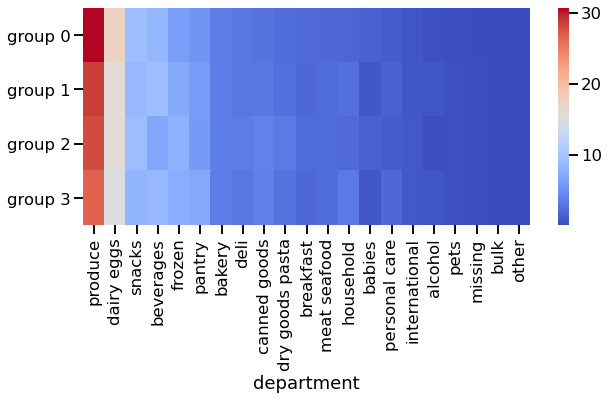

In [48]:
fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(department_rank.T,cmap="coolwarm")
plt.show()

In [52]:
group_name = list(department_rank.columns)
department_rank= department_rank.reset_index()
department_rank_long = pd.melt(department_rank,id_vars=['department'],value_vars=group_name)

department_rank_long.columns = ['department','group_num','Percentage']
department_rank_long

,department,group_num,Percentage
0,produce,group 0,30.675859
1,dairy eggs,group 0,17.639875
2,snacks,group 0,9.103118
3,beverages,group 0,8.324970
4,frozen,group 0,6.122335
...,...,...,...
79,alcohol,group 3,0.787061
80,pets,group 3,0.364269
81,missing,group 3,0.210964
82,bulk,group 3,0.076769


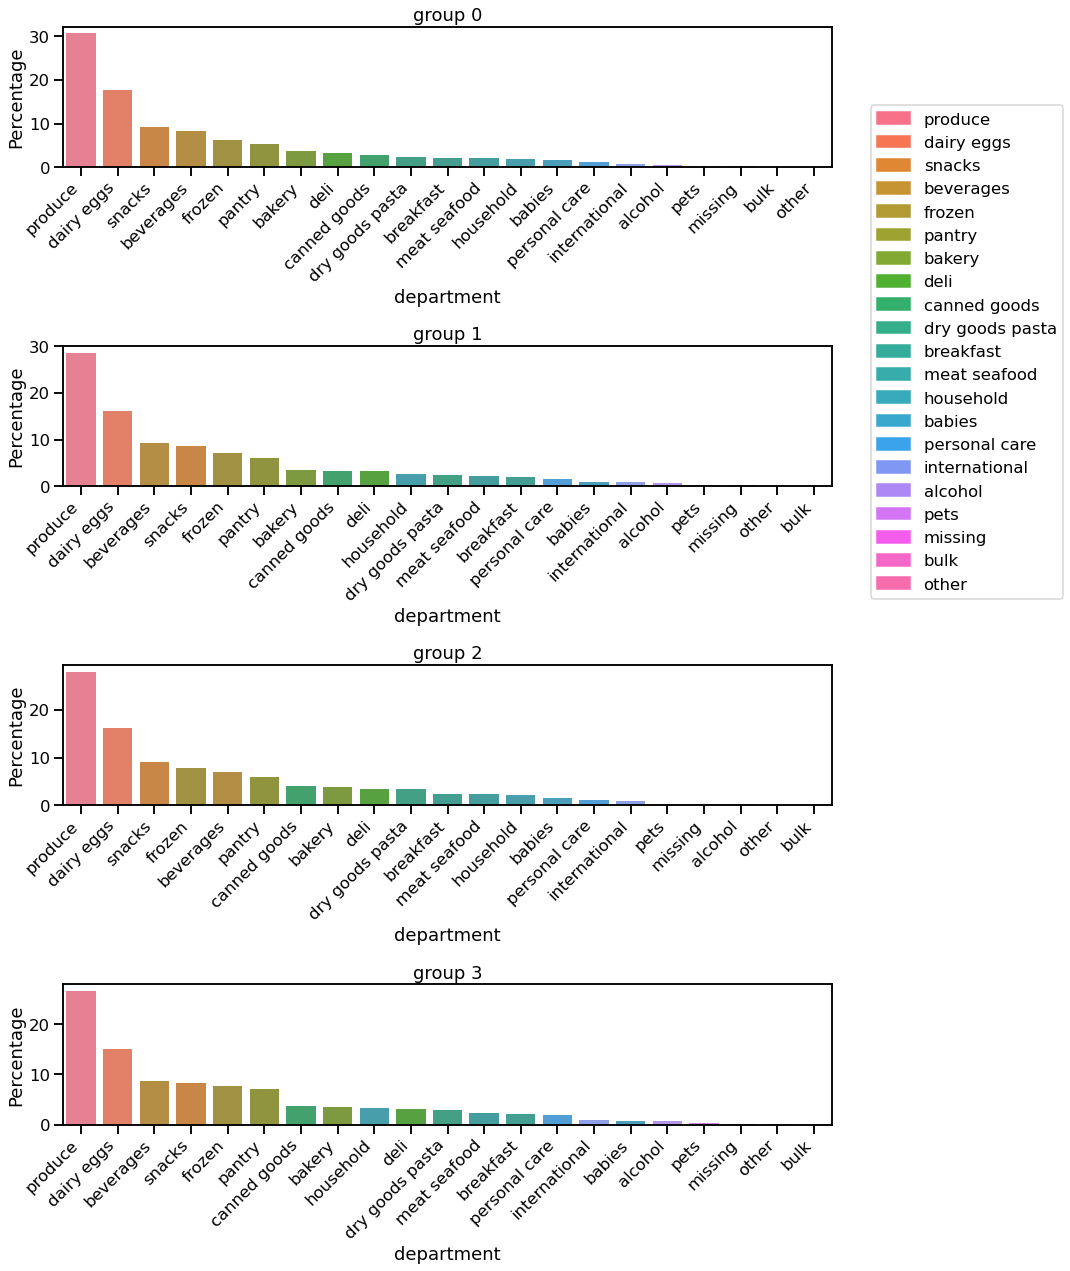

In [53]:
from matplotlib.patches import Patch

place_cat = department_rank_long.department.unique()
group_list = sorted(list(set(department_rank_long.group_num)))
colors = sns.color_palette('husl', n_colors=21)
cmap = dict(zip(place_cat, colors))

# plot a subplot for each group_num
plt.figure(figsize=(12, 18))
for i, tod in enumerate(department_rank_long.group_num.unique(), 1):
    data = department_rank_long[department_rank_long.group_num == tod].sort_values(['Percentage'], ascending=False)
    plt.subplot(4, 1, i)
    p = sns.barplot(x='department', y='Percentage', data=data, hue='department', palette=cmap,dodge=False)
    p.legend_.remove()
    plt.xticks(rotation=45,ha='right')
    plt.title(f'{tod}')

plt.tight_layout()
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 5.5), loc='center left', borderaxespad=0)
plt.show()

### Department by shopping habits

In [54]:
habit_department_rank = (department_orders[department_orders["habit_groups"]==0].groupby("department")[["num_of_orders"]].sum())*100/(department_orders[department_orders["habit_groups"]==0][["num_of_orders"]].sum())
habit_department_rank.rename(columns={"num_of_orders":"group "+str(0)},inplace=True)
for i in range(1,4):
    department_temp = (department_orders[department_orders["habit_groups"]==i].groupby("department")[["num_of_orders"]].sum())*100/(department_orders[department_orders["habit_groups"]==i][["num_of_orders"]].sum())
    department_temp.rename(columns={"num_of_orders":"group "+str(i)},inplace=True)
    habit_department_rank=pd.concat([habit_department_rank,department_temp],axis=1)

In [55]:
habit_department_rank=habit_department_rank.sort_values(by='group 0',ascending=False)
habit_department_rank.head()

,group 0,group 1,group 2,group 3
department,,,,
produce,31.226778,29.330253,28.368841,28.418971
dairy eggs,16.359350,16.377163,16.394533,17.600083
snacks,7.669066,8.088729,9.173459,10.410189
frozen,7.317075,7.691168,6.937842,5.729645
beverages,6.760287,8.109259,8.535917,9.472105


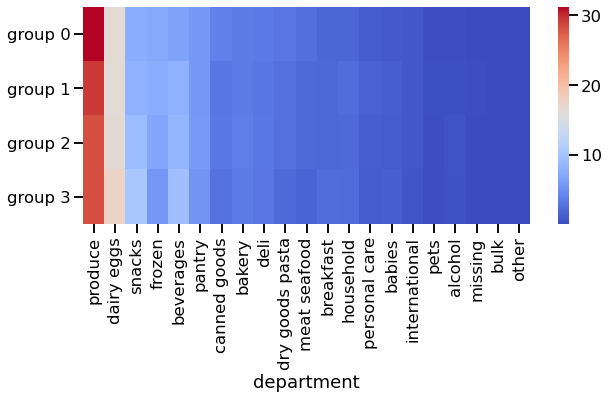

In [56]:
fig, ax = plt.subplots(figsize=(10,4))
sns.heatmap(habit_department_rank.T,cmap="coolwarm")
plt.show()

In [57]:
group_name = list(habit_department_rank.columns)
habit_department_rank= habit_department_rank.reset_index()
habit_department_rank_long = pd.melt(habit_department_rank,id_vars=['department'],value_vars=group_name)

habit_department_rank_long.columns = ['department','group_num','Percentage']
habit_department_rank_long

,department,group_num,Percentage
0,produce,group 0,31.226778
1,dairy eggs,group 0,16.359350
2,snacks,group 0,7.669066
3,frozen,group 0,7.317075
4,beverages,group 0,6.760287
...,...,...,...
79,pets,group 3,0.226094
80,alcohol,group 3,0.501358
81,missing,group 3,0.202811
82,bulk,group 3,0.111197


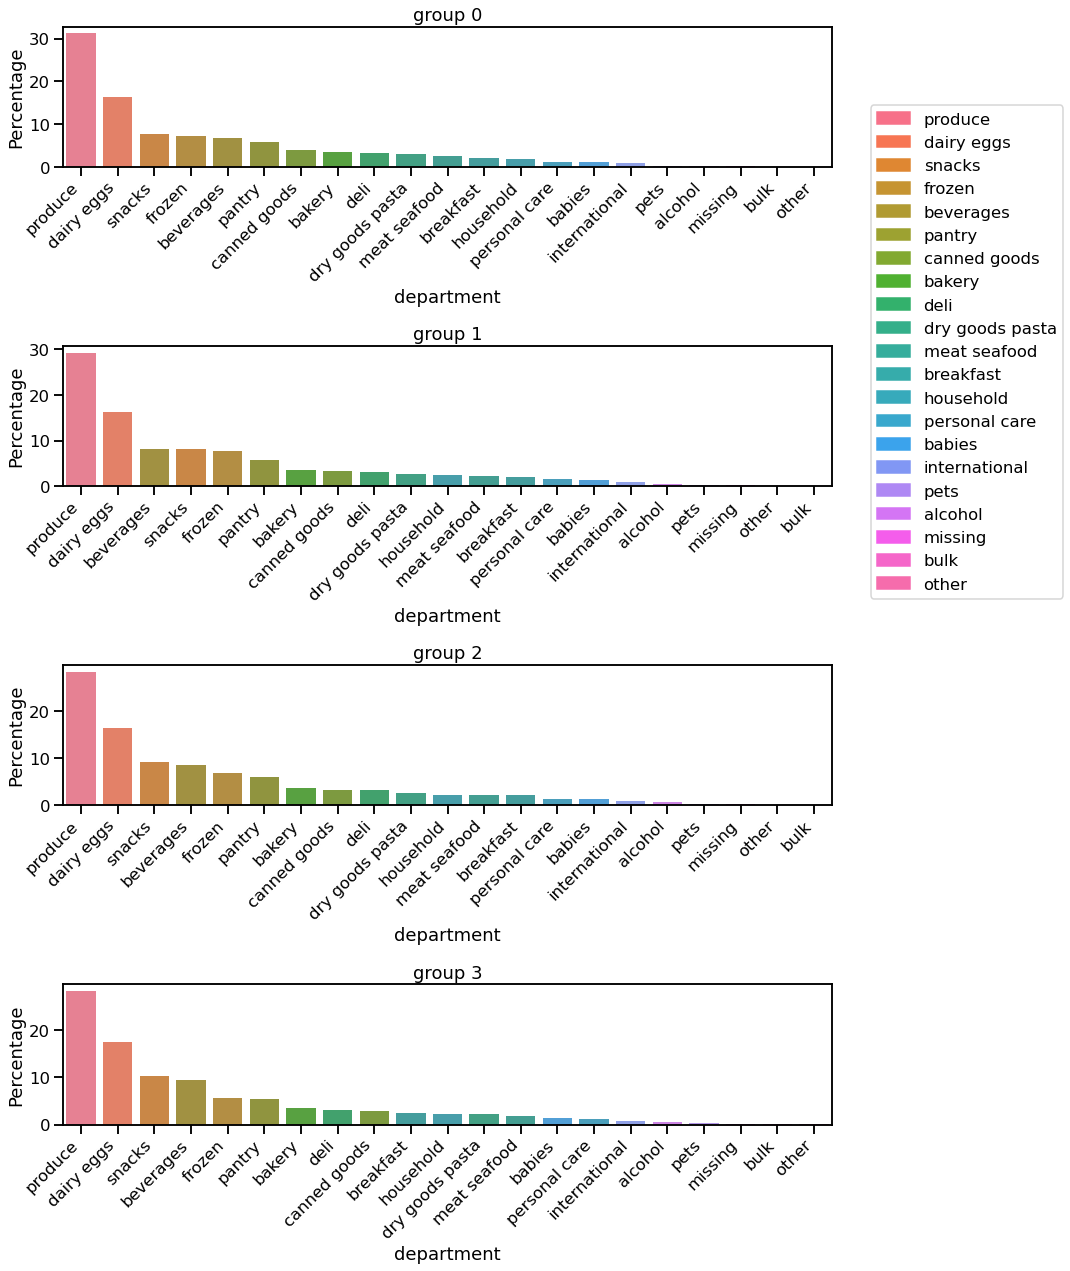

In [58]:
place_cat = habit_department_rank_long.department.unique()
colors = sns.color_palette('husl', n_colors=21)
cmap = dict(zip(place_cat, colors))

# plot a subplot for each group_num
plt.figure(figsize=(12, 18))
for i, tod in enumerate(habit_department_rank_long.group_num.unique(), 1):
    data = habit_department_rank_long[habit_department_rank_long.group_num == tod].sort_values(['Percentage'], ascending=False)
    plt.subplot(4, 1, i)
    p = sns.barplot(x='department', y='Percentage', data=data, hue='department', palette=cmap,dodge=False)
    p.legend_.remove()
    plt.xticks(rotation=45,ha='right')
    plt.title(f'{tod}')

plt.tight_layout()
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 5.5), loc='center left', borderaxespad=0)
plt.show()

## What are the top Five products people frequently buy in each group?

In [59]:
statement = 'SELECT user_id, o.order_id, p.product_id, product_name from orders o join order_details od on o.order_id=od.order_id inner join products p on od.product_id = p.product_id;'
all_products = sql_data(statement)

## What are the first items people put into the shopping cart

In [60]:
statement = 'SELECT user_id, o.order_id, p.product_id, product_name from orders o join order_details od on o.order_id=od.order_id inner join products p on od.product_id = p.product_id where add_to_cart_order=1;'
first_items =sql_data(statement)

In [61]:
first_items.head()

,user_id,order_id,product_id,product_name
0,202279,2,33120,Organic Egg Whites
1,205970,3,33754,Total 2% with Strawberry Lowfat Greek Strained...
2,178520,4,46842,Plain Pre-Sliced Bagels
3,156122,5,13176,Bag of Organic Bananas
4,22352,6,40462,Cleanse


In [62]:
cf_first_items =pd.merge(first_items,feature_group,on='user_id')

cf_first_count = cf_first_items.groupby(['feature_groups','product_name'])['order_id'].count().reset_index()
cf_first_count.columns =['feature_group','Product_name','Count']

cf_first_count["RANK"] = cf_first_count.groupby("feature_group")["Count"].rank(method="first", ascending=False)
cf_first_count.head()

,feature_group,Product_name,Count,RANK
0,0,#2 Coffee Filters,52,3877.0
1,0,#2 Cone White Coffee Filters,1,24993.0
2,0,#4 Natural Brown Coffee Filters,14,9272.0
3,0,& Go! Hazelnut Spread + Pretzel Sticks,9,11827.0
4,0,(70% Juice!) Mountain Raspberry Juice Squeeze,1,24994.0


In [63]:
cf_top10 = cf_first_count[cf_first_count['RANK']<=10].sort_values(['feature_group','RANK']).reset_index(drop=True)

In [64]:
cf_top10.head()

,feature_group,Product_name,Count,RANK
0,0,Banana,52990,1.0
1,0,Bag of Organic Bananas,40875,2.0
2,0,Organic Whole Milk,16496,3.0
3,0,Organic Strawberries,14419,4.0
4,0,Organic Hass Avocado,12333,5.0


In [65]:
cf_top10 = cf_top10.pivot(index='RANK', columns='feature_group', values='Product_name')

In [66]:
cf_top10

feature_group,0,1,2,3
RANK,,,,
1.0,Banana,Banana,Banana,Banana
2.0,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas
3.0,Organic Whole Milk,Organic Whole Milk,Organic Avocado,Organic Baby Spinach
4.0,Organic Strawberries,Organic Baby Spinach,Organic Whole Milk,Organic Avocado
5.0,Organic Hass Avocado,Organic Strawberries,Organic Hass Avocado,Organic Strawberries
6.0,Organic Baby Spinach,Organic Avocado,Organic Strawberries,Organic Whole Milk
7.0,Organic Avocado,Organic Hass Avocado,Organic Baby Spinach,Strawberries
8.0,Spring Water,Spring Water,Organic Raspberries,Organic Hass Avocado
9.0,Organic Raspberries,Strawberries,Sparkling Water Grapefruit,Soda
